### 1 对单个数字进行分类的数据预处理步骤

作者 meelo

### 1.1 Street View House Numbers (SVHN) 数据集

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

![](http://ufldl.stanford.edu/housenumbers/32x32eg.png)
Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 

### 下载并加载数据集

下载训练数据集和测试数据集，可以手动下载下面链接的数据，并放置到此notebook同一文件夹。  
运行下面的程序可以直接在Linux系统中下载数据。  
训练数据集： http://ufldl.stanford.edu/housenumbers/train_32x32.mat  
测试数据集： http://ufldl.stanford.edu/housenumbers/test_32x32.mat  
额外数据集： http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.  
73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data

In [10]:
%%bash
url=http://ufldl.stanford.edu/housenumbers/
train=train_32x32.mat
test=test_32x32.mat
extra=extra_32x32.mat
if [ ! -f $train ]; then
  wget $url$train
  echo "Successfully download training dataset"
fi
if [ ! -f $test ]; then
  wget $url$test
  echo "Successfully download testing dataset"
fi
if [ ! -f $extra ]; then
  wget $url$extra
  echo "Successfully download extra dataset"
fi

In [1]:
# load file from .mat fi
from __future__ import print_function
from scipy import io

train_raw = io.loadmat('train_32x32.mat')
train_dataset = train_raw['X']
train_labels = train_raw['y']

print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)

test_raw = io.loadmat('test_32x32.ma
                      t')
test_dataset = test_raw['X']
test_labels = test_raw['y']

print('Testing dataset shape: ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

extra_raw = io.loadmat('extra_32x32.mat')
extra_dataset = extra_raw['X'][:,:,:,:10000]
extra_labels = extra_raw['y'][:10000]

print('Extra dataset shape: ', extra_dataset.shape)
print('Extra labels shape: ', extra_labels.shape)


Training dataset shape:  (32, 32, 3, 73257)
Training labels shape:  (73257, 1)
Testing dataset shape:  (32, 32, 3, 26032)
Testing labels shape:  (26032, 1)
Extra dataset shape:  (32, 32, 3, 10000)
Extra labels shape:  (10000, 1)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

%matplotlib inline

In [3]:
train_dataset = np.rollaxis(train_dataset, 3, 0) # Make the third dimension zeroth dimension
train_labels = train_labels.flatten()

extra_dataset = np.rollaxis(extra_dataset, 3, 0) # Make the third dimension zeroth dimension
extra_labels = extra_labels.flatten()

test_dataset = np.rollaxis(test_dataset, 3, 0) # Make the third dimension zeroth dimension
test_labels = test_labels.flatten()

### 查看数据的分布

可以看到在训练数据集中，不同数字出现的频率有较大差异。数字1出现的频率是数字9出现频率的3倍。  
数据集的说明中并没有描述，数据是如何采集的以及数字的分布是否是真实世界的分布。  
测试集数字的分布与训练集基本相同，说明如果分类器在训练集中有较好地分类正确率，那么在测试集中也会有同样的分类正确率。  
另一方面，训练数据集数字的不均匀分布会使得分类器更倾向于某个数字分类的正确性，也就是更倾向于分类为那个数字。

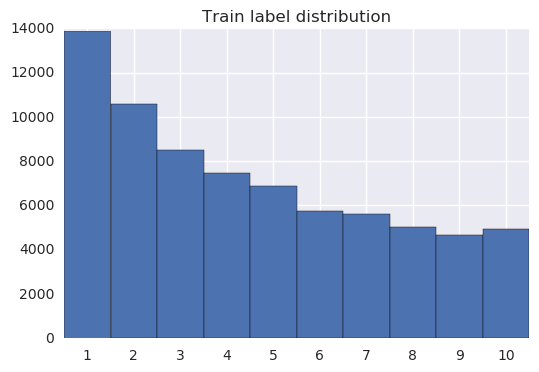

In [4]:
NUM_LABELS = 10

plt.xticks(np.arange(1, NUM_LABELS+1))
plt.hist(train_labels, bins=np.arange(1, NUM_LABELS+2)-0.5)
plt.title('Train label distribution')

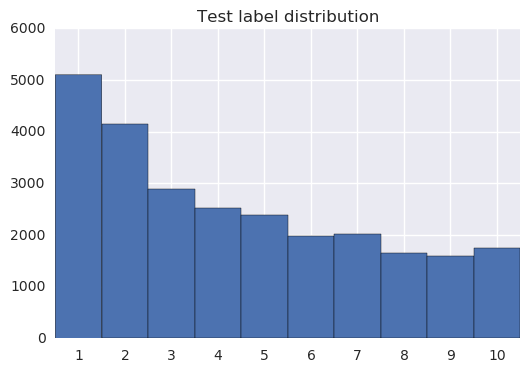

In [6]:
plt.xticks(np.arange(1, NUM_LABELS+1))
plt.hist(test_labels, bins=np.arange(1, NUM_LABELS+2)-0.5)
plt.title('Test label distribution')

在论文[《Convolutional Neural Networks Applied to House Numbers Digit Classification》](https://arxiv.org/pdf/1204.3968.pdf)中，训练数据每一类数字选择600张图片，2/3来自train_32x32.mat，1/3来自extra_32x32.mat。总共6000张图片，注意到这个数字远远小于可以用于训练的图片数量。

In [5]:
train_dataset = np.vstack((
        np.vstack(train_dataset[train_labels == i][:800] for i in range(1,11)),
        np.vstack(extra_dataset[extra_labels == i][:200] for i in range(1,11))
    ))
train_labels = np.hstack((
        np.hstack(train_labels[train_labels == i][:800] for i in range(1,11)),
        np.hstack(extra_labels[extra_labels == i][:200] for i in range(1,11))
    ))

print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)

Training dataset shape:  (10000, 32, 32, 3)
Training labels shape:  (10000,)


### 构建交叉验证数据集(cross validation dataset)

原始数据中并不包含用于交叉验证验证的数据。
从训练数据中选择1%作为交叉验证数据集。交叉验证数据集不需要很大。因为我们通常使用随机梯度下降训练深度学习模型，每一次都只使用训练数据集中的一小部分。  
开始犯了一个错误，把交叉验证集设置得太大
 

In [6]:
valid_dataset = np.vstack((
        np.vstack(train_dataset[train_labels == i][800:840] for i in range(1,11)),
        np.vstack(extra_dataset[extra_labels == i][400:430] for i in range(1,11))
    ))
valid_labels = np.hstack((
        np.hstack(train_labels[train_labels == i][800:840] for i in range(1,11)),
        np.hstack(extra_labels[extra_labels == i][400:430] for i in range(1,11))
    ))

print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)

Validing dataset shape:  (700, 32, 32, 3)
Validing labels shape:  (700,)


### 随机打乱原始数据


In [7]:
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
seed = 42
np.random.seed(seed)

train_dataset, train_labels = shuffle_in_unison_inplace(train_dataset, train_labels)

print('Training dataset shape (grey scale): ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)

valid_dataset, valid_labels = shuffle_in_unison_inplace(valid_dataset, valid_labels)

print('Validing dataset shape (grey scale): ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)

Training dataset shape (grey scale):  (10000, 32, 32, 3)
Training labels shape:  (10000,)
Validing dataset shape (grey scale):  (700, 32, 32, 3)
Validing labels shape:  (700,)


### 修改数据的格式

在原始数据集中，图片的格式是RGB。然而，图片的颜色对于数字的识别来说，通常没有价值。将彩色图片转换成灰度图能够将数据集的大小减小3倍。  
从上面数据集的形状可以看到，第1维和第2维表示图片的高与宽，第3维表示图片的色彩通道，第4维表示不同的图片。通常在机器学习中，用第1维表示不同的样本，将使用numpy.rollaxis函数修改维度的顺序。  

In [9]:
import numpy as np


train_dataset = train_dataset.mean(3) # In CNN ,we keep the third dimension as channel keepdims=True

print('Training dataset shape (grey scale): ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)

valid_dataset = valid_dataset.mean(3)
print('Validing dataset shape (grey scale): ', valid_dataset.shape)

test_dataset = test_dataset.mean(3) # In CNN ,we keep the third dimension as channel

print('Testing dataset shape (grey scale): ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

Training dataset shape (grey scale):  (10000, 32, 32)
Training labels shape:  (10000,)
Validing dataset shape (grey scale):  (700, 32, 32)
Testing dataset shape (grey scale):  (26032, 32, 32)
Testing labels shape:  (26032,)


### 图片减去均值
将图片的表示范围变换成(-0.5, 0.5)

In [10]:
pixel_depth = 255.0  # Number of levels per pixel.

train_dataset = (train_dataset - pixel_depth / 2 ) / pixel_depth
valid_dataset = (valid_dataset - pixel_depth / 2 ) / pixel_depth
test_dataset = (test_dataset - pixel_depth / 2 ) / pixel_depth

In [11]:
print(train_dataset[0])

[[ 0.04117647  0.03464052  0.04248366 ..., -0.05686275 -0.10130719
  -0.09738562]
 [-0.03202614 -0.04509804 -0.03071895 ..., -0.06339869 -0.11176471
  -0.10915033]
 [-0.14575163 -0.15751634 -0.14183007 ..., -0.06078431 -0.1130719
  -0.11437908]
 ..., 
 [ 0.0254902   0.02026144  0.03594771 ...,  0.02287582 -0.04771242
  -0.1130719 ]
 [ 0.03986928  0.03594771  0.03986928 ...,  0.03464052 -0.03071895
  -0.10784314]
 [ 0.04379085  0.04248366  0.04771242 ...,  0.04117647 -0.02941176
  -0.10784314]]


### 数据的可视化

在我们继续进行下一步操作之前，非常有必要查看数据的格式是否符合预期的要求。我们的数据是图片，可视化就可以简单地把图片画出来，并对比图片的标签是否正确。  
在绘制图片的时候，使用参数`interpolation='none'`禁止使用插值，能够显示出图片的原始像素。  
分析样本图片可见，很多图片中数字并非只有一个，而是有多个，这增加了问题的难度。标签的数字位于图片的中央。  
有些图片在灰度图中，即使是人也难以分辨。  
图片还存在不同程度的旋转。

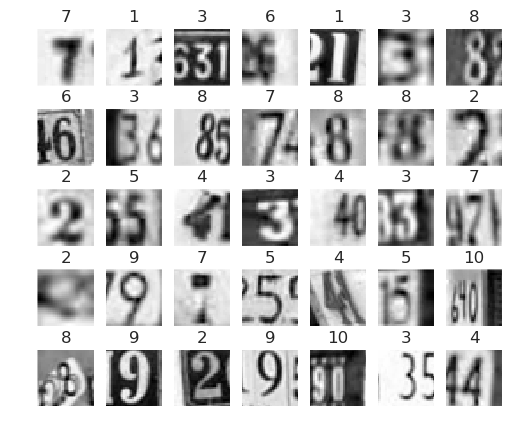

In [12]:
# Make sure image still look good
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
for ax in axes.flatten():
    random_idx = random.randint(0, train_dataset.shape[0]-1)
    ax.axis('off')
    ax.imshow(train_dataset[random_idx], cmap=plt.cm.gray, interpolation='none')
    ax.set_title(train_labels[random_idx])

### 保存经过预处理的数据

pickle模块实现了一种算法，将任意一个Python对象转化成一系列字节（byets）。此过程也调用了serializing对象。代表对象的字节流之后可以被传输或存储，再重构后创建一个拥有相同特征（the same characteristics）的新的对象。  
cPickle使用C而不是Python，实现了相同的算法。这比Python实现要快好几倍，但是它不允许用户从Pickle派生子类。如果子类对你的使用来说无关紧要，那么cPickle是个更好的选择。

保存4维数据还是3维数据
775MB→658MB

In [13]:
# save processed data in a pickle file
from six.moves import cPickle as pickle

dataset = {
    'train_dataset': train_dataset,
    'train_labels': train_labels, 
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels
}

pickle_file = 'svhn_single.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)